# Benchmarking numpy / scikit-image / scipy vs  clesperanto

In [1]:
import pyclesperanto_prototype as cle

cle.select_device('RTX')

<GeForce RTX 2070 on Platform: NVIDIA CUDA (1 refs)>

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

num_iterations = 10

# measure execution time of a given method
def benchmark(function, kwargs):
    times = []
    for i in range(0, num_iterations):
        start_time = time.time()
        function(**kwargs)
        delta_time = time.time() - start_time
        times = times + [delta_time]
        # print(delta_time)

    # return median of measurements to ignore warmup-effects
    return np.median(times)



def benchmark_size(method_np, method_cle, method_cle_alloc):
    times_ref = []
    times_cle = []
    times_cle_alloc = []
    sizes = []
    for size in [1, 2, 4, 8, 16, 32, 64]:

        input1 = np.zeros((1024, 1024, size))
        cl_input1 = cle.push(input1)
        cl_input2 = cle.create(cl_input1.shape)

        time_ref = benchmark(method_np, {"image":input1})
        time_cle = benchmark(method_cle, {"image":cl_input1, "output":cl_input2})
        time_cle_alloc = benchmark(method_cle_alloc, {"image":cl_input1})

        times_ref = times_ref + [time_ref]
        times_cle = times_cle + [time_cle]
        times_cle_alloc = times_cle_alloc + [time_cle_alloc]
        sizes = sizes + [size]

    plt.plot(sizes, times_ref,  'r--', sizes, times_cle, 'g--', sizes, times_cle_alloc, 'b--');
    plt.ylabel('Time / ms')
    plt.xlabel('Image size / MB')
    plt.legend(("ref", "cle", "cle+alloc"));
    plt.show()


    print("\nSizes (MB)        " + str(sizes))
    print("Times ref (s)       " + str(np.round(times_ref, 4)))
    print("Times cle (s)       " + str(np.round(times_cle, 4)))
    print("Times cle+alloc (s) " + str(np.round(times_cle_alloc, 4)))


## Thresholding

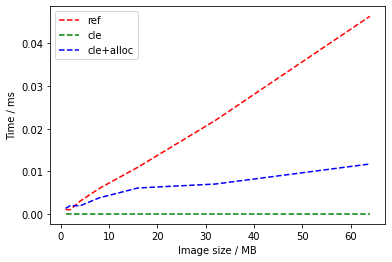


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.001  0.001  0.003  0.006  0.011  0.0219 0.0464]
Times cle (s)       [0. 0. 0. 0. 0. 0. 0.]
Times cle+alloc (s) [0.0013 0.0019 0.0019 0.0038 0.0061 0.007  0.0117]


In [3]:
# RED: thresholding of a numpy array
def threshold_ref(image):
    thresholded = image > 100
    return thresholded

# GREEN: thresholding of a pre-existing opencl array (no push, pull or alloc)
def threshold_cle(image, output):
    cle.greater_constant(image, output, 100)

# BLUE: allocate result memory + thresholding 
def threshold_cle_alloc(image):
    thresholded = cle.create(image.shape)
    cle.greater_constant(image, thresholded, 100)

benchmark_size(threshold_ref, threshold_cle, threshold_cle_alloc)

## Gaussian blur radius 2

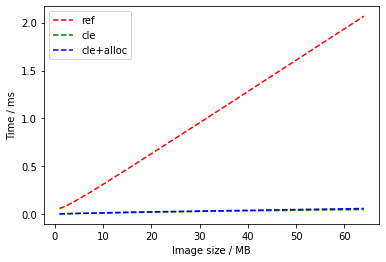


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.0613 0.0773 0.1302 0.2473 0.5017 1.0191 2.0668]
Times cle (s)       [0.0048 0.0053 0.0064 0.0097 0.0176 0.0313 0.0498]
Times cle+alloc (s) [0.0035 0.0055 0.0083 0.0125 0.0223 0.035  0.0601]


In [4]:
from skimage.filters import gaussian

radius = 2

def gaussian_blur_filter_ref(image):
    filtered = gaussian(image, sigma=radius)
    return filtered

def gaussian_blur_filter_cle(image, output):
    cle.gaussian_blur(image, output, radius, radius, radius)

def gaussian_blur_filter_cle_alloc(image):
    filtered = cle.create(image.shape)
    cle.gaussian_blur(image, filtered, radius, radius, radius)

benchmark_size(gaussian_blur_filter_ref, gaussian_blur_filter_cle, gaussian_blur_filter_cle_alloc)


## Gaussian blur radius 10

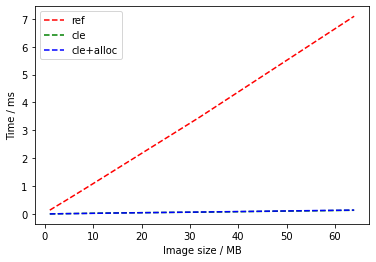


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.1386 0.2451 0.4528 0.8782 1.7417 3.4711 7.0918]
Times cle (s)       [0.004  0.0083 0.013  0.0229 0.0427 0.0666 0.1341]
Times cle+alloc (s) [0.0045 0.0077 0.0131 0.0203 0.039  0.0718 0.1421]


In [5]:
radius = 10
benchmark_size(gaussian_blur_filter_ref, gaussian_blur_filter_cle, gaussian_blur_filter_cle_alloc)


## Binary erosion

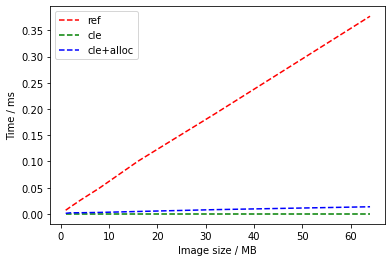


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.007  0.0135 0.0259 0.0494 0.1007 0.1915 0.377 ]
Times cle (s)       [0. 0. 0. 0. 0. 0. 0.]
Times cle+alloc (s) [0.0012 0.0021 0.0022 0.0028 0.0047 0.0082 0.0136]


In [6]:

from skimage.morphology import binary_erosion


def binary_erosion_ref(image):
    filtered = binary_erosion(image)
    return filtered

def binary_erosion_cle(image, output):
    cle.erode_box(image, output)

def binary_erosion_cle_alloc(image):
    filtered = cle.create(image.shape)
    cle.erode_box(image, filtered)

benchmark_size(binary_erosion_ref, binary_erosion_cle, binary_erosion_cle_alloc)



## Mean filter radius=2

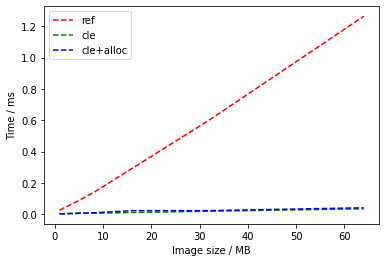


Sizes (MB)        [1, 2, 4, 8, 16, 32, 64]
Times ref (s)       [0.0249 0.0419 0.0713 0.1376 0.292  0.6007 1.2639]
Times cle (s)       [0.0033 0.004  0.0051 0.0071 0.0113 0.0198 0.0351]
Times cle+alloc (s) [0.0025 0.0034 0.0067 0.0094 0.0232 0.0236 0.0418]


In [7]:

import scipy.ndimage.filters as spf


radius = 2
def mean_filter_ref(image):
    # todo: not sure if size is a radius or a diameter. Check documentation
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter.html#scipy.ndimage.uniform_filter
    filtered = spf.uniform_filter(image, size=radius)
    return filtered

def mean_filter_cle(image, output):
    cle.mean_box(image, output, radius, radius, radius)

def mean_filter_cle_alloc(image):
    filtered = cle.create(image.shape)
    cle.mean_box(image, filtered, radius, radius, radius)

benchmark_size(mean_filter_ref, mean_filter_cle, mean_filter_cle_alloc)
